In [2]:
import random
from tqdm.notebook import tqdm
import numpy as np
from IPython.display import clear_output
from importlib import reload

import gym
import matplotlib.pyplot as plt
import wandb
import torch

from Learning.utils import ReplayBuffer, plot, plot_test_trajectory, PER_IS_ReplayBuffer
import Learning.agents as ag
import Envs.AYS.AYS_Environment as ays

In [11]:
UPDATE_ONLINE = False
BATCH_SIZE = 256
MAX_EPISODES = 2000
RANDOM_EXPERIENCE = 0
LEARNING_RATE = 3e-4
BUFFER_SIZE = 2**14
REWARD_TYPE = 'PB'
DT = 1
SCHEDULER = (False, 1000, 0.5)
SEED = 0
MAX_STEPS = 600

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

wandbsave = False

config = {
    "learning_rate": LEARNING_RATE,
    "max_episodes": MAX_EPISODES,
    "batch_size": BATCH_SIZE, 
    "online_updating": UPDATE_ONLINE,
    "random_experience": RANDOM_EXPERIENCE,
    "buffer_size": BUFFER_SIZE,
    "reward_type": REWARD_TYPE,
    "dt": DT,
    "scheduler": SCHEDULER,
    "seed": SEED
}
reload(ays)
env = ays.AYS_Environment(discount=0.99,dt=DT, reward_type=REWARD_TYPE)
state_dim = len(env.observation_space)
action_dim = len(env.action_space)

reload(ag)
memory = PER_IS_ReplayBuffer(BUFFER_SIZE, alpha=0.6)
agent = ag.A2C(state_dim, action_dim, alpha=LEARNING_RATE)

scheduler = torch.optim.lr_scheduler.StepLR(agent.optimizer, step_size=SCHEDULER[1], gamma=SCHEDULER[2])

if wandbsave:
    wandb.init(name="AYS_PPO2_policy_cost",config=config,
               entity="climate_policy_optim",  project="AYS_learning")
    wandb.watch(agent.ac_net)

Init AYS Environment! 
Reward Type: PB 
Sustainability Boundaries [A_PB, Y_SF, S_ren]:  [3.45e+02 4.00e+13 0.00e+00]


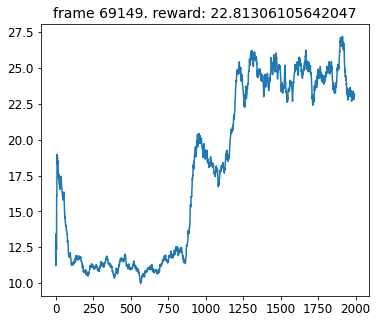

In [12]:
rewards = []
mean_rewards = []
frame_idx = 0
beta = 0.6

for episodes in tqdm(range(MAX_EPISODES)):
    state = env.reset()
    episode_reward = 0
    done = False

    for i in range(MAX_STEPS):
        if episodes>RANDOM_EXPERIENCE:
            action = agent.get_action(state)
        else:
            action = np.random.choice(action_dim)
            
        next_state, reward, done,  = env.step(action)
        
        
        episode_reward += reward
        
        if UPDATE_ONLINE:
            loss = agent.online_update((state, action, reward, next_state, done))
            if wandbsave:
                wandb.log({'loss': loss})
        else:
            memory.push(state, action, reward, next_state, done)
            
        
        state = next_state
        frame_idx += 1 
        if done:
            break
        
    rewards.append(episode_reward)
    mean_rewards.append(np.mean(rewards[-50:]))
    
    if not UPDATE_ONLINE:
        if memory.size > BATCH_SIZE:
            beta = 1-0.4*np.exp(-0.001*episodes) # we converge beta to 1
            sample = memory.sample(BATCH_SIZE, beta)
            loss, tds = agent.update((sample['obs'], sample['action'], sample['reward'], sample['next_obs'], sample['done']))
            new_tds = np.abs(tds.cpu().numpy()) + 1e-6 # compatibility
            memory.update_priorities(sample['indexes'], new_tds)
            if wandbsave:
                wandb.log({'loss': loss})    
                
    if SCHEDULER[0]:
        scheduler.step()
    
    if wandbsave:
        wandb.log({'episode_reward':episode_reward})
        if episodes%200==0:
                plot_test_trajectory(env, agent)
            
    else:
        if episodes%10==0:
            plot(frame_idx, mean_rewards)
            if episodes%30==0:
                plot_test_trajectory(env, agent)

if wandbsave:
    wandb.run.summary["mean_reward"] = np.mean(rewards)
    wandb.run.summary["top_reward"]= max(rewards)
    wandb.finish()

In [ ]:
plot_test_trajectory(env, agent)

# Using function

In [19]:
import learning_loop as ll
reload(ll)
from learning_loop import learning_loop
from Learning import utils
from Learning import agents as ag
import learn_class as lc
reload(lc)

<module 'learn_class' from 'C:\\Users\\theod\\PycharmProjects\\climate_policy_thesis\\climate_policy_RL\\classes\\learn_class.py'>

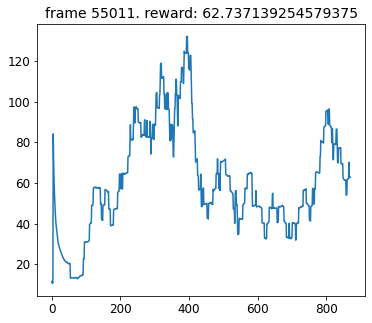

In [ ]:
reload(lc)
experiment = lc.learning(max_frames=1e6, max_episodes=3000)
experiment.set_agent("DuelDDQN", epsilon=0.1, lr=3e-4)
experiment.learning_loop_offline("DuelDDQN", buffer_size=2**14, batch_size=128, per_is=True, notebook=True, plotting=False)

In [ ]:
reload(lc)
experiment = lc.observability(max_frames=1e6, max_episodes=3000)
experiment.set_agent("DuelDDQN", epsilon=0.1, lr=3e-4)
experiment.learning_loop_offline("DuelDDQN", buffer_size=2**14, batch_size=128, per_is=True, notebook=True, plotting=False)